In [1]:
%load_ext autoreload
%autoreload 2
import featureman.gen_data as man
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [16]:
# seed
torch.manual_seed(1337)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = man.OneLayerTransformer(p=113, d_model=128).to(device)

dataset = man.ModularArithmeticDataset(p=113, n_samples=113**2)
train_size = int(0.3 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)
#full batch size
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1)
criterion = nn.CrossEntropyLoss()

In [17]:
# Track losses
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(1500):
    # Training
    model.train()
    epoch_train_loss = 0
    correct = 0
    total = 0

    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # The batch is a dictionary with keys, not a list of dictionaries
        input_ids = batch["inputs"].long().to(device)
        labels = batch["labels"].long().to(device)

        logits = model(input_ids)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    # Testing
    model.eval()
    epoch_test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch["inputs"].long().to(device)
            labels = batch["labels"].long().to(device)

            logits = model(input_ids)
            loss = criterion(logits, labels)

            epoch_test_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    # Calculate averages
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    avg_test_loss = epoch_test_loss / len(test_dataloader)
    train_acc = 100 * correct / total
    test_acc = 100 * test_correct / test_total

    # Store metrics
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"\nEpoch {epoch} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print("-" * 50)

print("\nTraining Complete!")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

Epoch 0, Batch 0, Loss: 4.8960

Epoch 0 Summary:
Train Loss: 4.7810, Train Acc: 1.10%
Test Loss: 4.7529, Test Acc: 1.24%
--------------------------------------------------
Epoch 1, Batch 0, Loss: 4.6972

Epoch 1 Summary:
Train Loss: 4.7053, Train Acc: 1.38%
Test Loss: 4.7537, Test Acc: 1.00%
--------------------------------------------------
Epoch 2, Batch 0, Loss: 4.6363

Epoch 2 Summary:
Train Loss: 4.6468, Train Acc: 2.87%
Test Loss: 4.7540, Test Acc: 1.34%
--------------------------------------------------
Epoch 3, Batch 0, Loss: 4.5947

Epoch 3 Summary:
Train Loss: 4.5659, Train Acc: 5.04%
Test Loss: 4.7642, Test Acc: 1.69%
--------------------------------------------------
Epoch 4, Batch 0, Loss: 4.4289

Epoch 4 Summary:
Train Loss: 4.4649, Train Acc: 6.50%
Test Loss: 4.7847, Test Acc: 2.13%
--------------------------------------------------
Epoch 5, Batch 0, Loss: 4.3876

Epoch 5 Summary:
Train Loss: 4.3476, Train Acc: 9.03%
Test Loss: 4.8233, Test Acc: 2.41%
-------------------

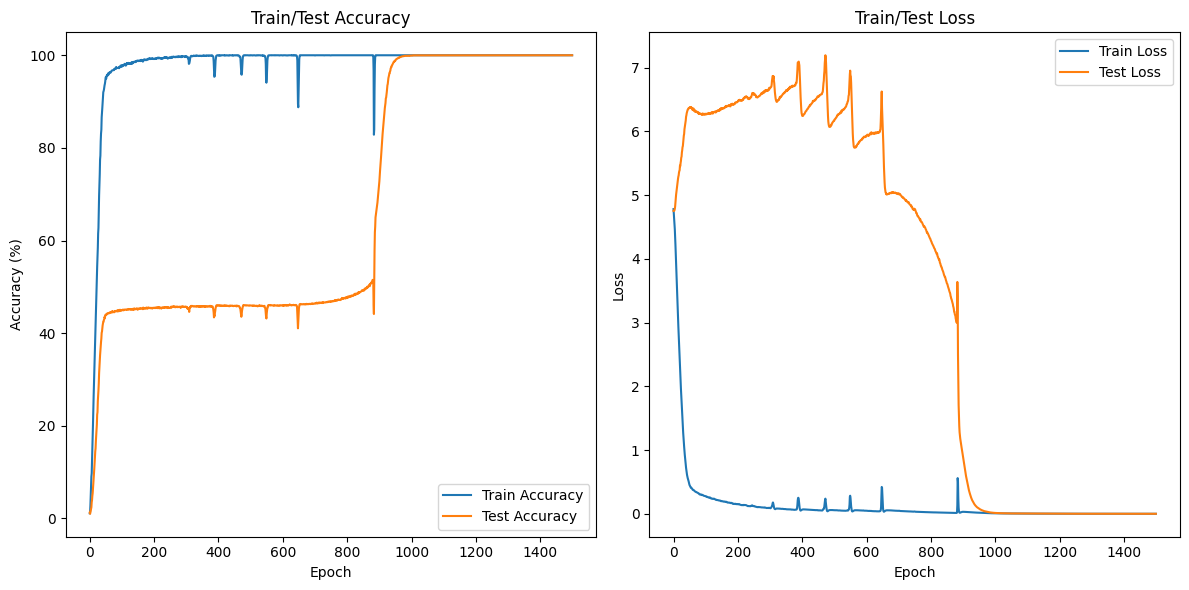

In [18]:
#side by side plot of train/test accuracies and losses
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train/Test Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
#save the model
torch.save(model.state_dict(), "modular_arithmetic_model.pth")
print("Model saved as modular_arithmetic_model.pth")

Model saved as modular_arithmetic_model.pth
